### 0. Import Modules & Setting Environments

In [ ]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_teddynote import logging
from Utils import init_llm
from Utils import postgres_conn
from Settings import env_path

In [33]:
load_dotenv(env_path)

True

In [2]:
# input your project name
logging.langsmith("Test_Demo_App")
llm = init_llm()
embedding_model_name = "BAAI/bge-m3"
db_conn = postgres_conn()

LangSmith 추적을 시작합니다.
[프로젝트명]
Test_Demo_App


### 1. Define State

In [3]:
from pydantic import BaseModel,Field
from typing import List,Literal,Optional
from typing import TypedDict
# 노드 1의 출력 구조를 정의할 Pydantic 모델
class Requirements(BaseModel):
    """사용자 프롬프트에서 추출된 요구사항"""
    school_level: str = Field(description="학교급 (예: 초등학교, 중학교, 고등학교)")
    grade: str = Field(description="학년 (예: 1학년, 2학년)")
    subject: str = Field(description="과목 (예: 수학, 과학)")
    content_requests: List[Literal["학습 목표 생성", "문제 생성"]] = Field(description="요청된 콘텐츠 유형 목록")
    domain: str = Field(description="핵심 학습 주제")
    basecode: str

# 데이터 모델 정의: 검색된 문서의 관련성을 이진 점수로 평가하기 위한 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved documents."""

    # 문서가 질문에 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
class ProblemState(TypedDict):
    problems: Optional[str]               # 노드의 결과 (생성된 문제)
    status: str                           # 노드 실행 상태 (success/failure)
    error_message: Optional[str]          # 에러 메시지
    
class GoalState(TypedDict):
    learning_goals: Optional[str]         # 노드의 결과 (생성된 학습 목표)
    status: str                           # 노드 실행 상태 (success/failure)
    error_message: Optional[str]          # 에러 메시지
    
class MainState(TypedDict):
    prompt: str                          # 사용자 초기 입력
    metadata: str                        # 과목 메타데이터
    requirements: Optional[Requirements]  # 노드 1의 결과 (추출된 요구사항)
    retrieved_docs: Optional[List[dict]]  # 노드 2의 결과 (벡터 DB 검색 결과)
    binary_score: str                    # 관련성 검증 노드의 결과 값
    final_response: Optional[str]        # 최종 답변

    # 병렬 노드들의 상태를 여기에 포함 (개별 객체로 관리)
    problem_state: Optional[ProblemState]
    goal_state: Optional[GoalState]


### 1-1 Define functions


In [4]:
def search_metadata(
    vector,
    conn,
    k=3,
    ):
    """pgvector에서 관련성 높은 문서를 k개 검색합니다."""
    with conn.cursor() as cursor:
        # 벡터 검색 시 필요한 모든 컬럼을 가져옵니다.
        cursor.execute(
            """SELECT basecode, content,school_level, grade, domain, category
                FROM curriculum
                ORDER BY embedding <=> %s::vector LIMIT %s""",
            (list(vector), k)
        )
        # 결과를 딕셔너리 리스트로 변환
        results = [
            dict(zip([desc[0] for desc in cursor.description], row))
            for row in cursor.fetchall()
        ]
        return results
def get_grader(llm):
    # GradeDocuments 데이터 모델을 사용하여 LLM의 구조화된 출력 생성
    structured_llm_grader = llm.with_structured_output(GradeDocuments)

    # 시스템 프롬프트 정의: 검색된 문서가 사용자 질문에 관련이 있는지 평가하는 시스템 역할 정의
    system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

    # 채팅 프롬프트 템플릿 생성
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )

    # 검색 평가기 생성
    retrieval_grader = grade_prompt | structured_llm_grader
    return retrieval_grader

### 2. Define Nodes

In [5]:
# Define nodes
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from sentence_transformers import SentenceTransformer
def extract_requirements_node(state: MainState) -> dict:
    """
    사용자 프롬프트를 입력받아서 메타데이터 및 요구사항을 추출
    메타데이터는 학교급, 학년, 도메인, 카테고리가 될 수 있음
    """
    prompt = state["prompt"]

    # LLM이 Pydantic 모델(Requirements)에 맞춰 구조화된 결과를 출력하도록 설정
    structured_llm = llm.with_structured_output(Requirements)
    # Pydantic 모델에 정의된 Literal 값을 가져옵니다.
    allowed_requests = Requirements.model_fields['content_requests'].annotation.__args__[0].__args__
    # 결과: ('학습 목표 생성', '문제 생성')

    system_prompt = f"""You are an expert at analyzing user requests for educational content creation.
    Extract the required information from the user's prompt.

    For the `content_requests` field, you MUST choose one or more values from the following exact list:
    {list(allowed_requests)}

    Do not use similar words or variations. For example, if the user asks for '연습 문제' or '퀴즈', you must map it to '문제 생성'. If they ask for '학습 목표'
    you must map it to '학습 목표 생성'.
    """

    # system_prompt = "You are an expert at analyzing user requests for educational content creation. Extract the required information from the user's prompt."
    user_prompt = f"다음 사용자 프롬프트에서 핵심 요구사항을 추출해줘:\n'{prompt}'"
    
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", user_prompt),
    ])
    
    chain = prompt_template | structured_llm
    extracted = chain.invoke({"prompt": prompt})
    
    print(f"-> 추출된 요구사항: {extracted}")

    return {"requirements": extracted}



def retrieve_from_db_node(state: MainState) -> dict:
    """
    추출된 요구사항 및 메타데이터 을 기반으로 벡터 DB에서 관련 메타데이터를 검색하는 노드
    """
    print("\n--- 2. 벡터 DB 검색 노드 실행 ---")
    requirements = state["requirements"]
    school_level = requirements.school_level
    grade = requirements.grade
    domain = requirements.domain
    subject = requirements.subject
    
    concated_metadata = f"{school_level} {grade} {subject} {domain}"
    model = SentenceTransformer(embedding_model_name)     
    embed_metadata = model.encode(concated_metadata)
    # gemini api로 임베딩 시도했으나 실패함
    # embed_metadata = client.models.embed_content(
    #     model="gemini-embedding-001",
    #     contents=concated_metadata,
    #     config=types.EmbedContentConfig(output_dimensionality=1024)
    # ).embeddings[0].values
    
    # 구축한 벡터 DB에서 검색
    retrieved_data = search_metadata(
        vector=embed_metadata,
        conn=db_conn
    )
    print([tuple(res.values()) for res in retrieved_data])
    
    return {
        "retrieved_docs": retrieved_data,
        "metadata":concated_metadata
    }

def consolidate_response_node(state: MainState) -> dict:
    """
    병렬로 생성된 콘텐츠들을 종합하여 최종 답변을 만듭니다.
    """
    print("\n--- 최종 답변 종합 노드 실행 ---")
    requirements = state["requirements"]
    problems = state['problem_state']['problems']
    learning_goals = state['goal_state']['learning_goals']
    

    final_response_parts = []
    final_response_parts.append(
        f"요청하신 **{requirements.school_level} {requirements.grade} {requirements.subject} - '{requirements.domain}'** 단원에 대한 콘텐츠입니다.\n"
    )

    if learning_goals:
        final_response_parts.append("### 학습 목표\n" + learning_goals.content)
    
    if problems:
        final_response_parts.append("\n### 연습 문제\n" + problems.content)
        
    final_response = "\n".join(final_response_parts)
    print("-> 최종 답변 생성 완료")
    
    return {"final_response": final_response}

/home/cheongwoon/workspace/Study-Agent/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def generate_learning_goals_node(state: MainState) -> dict:
    """
    입력된 정보를 바탕으로 학습 목표를 생성합니다. (병렬 처리 대상)
    """
    requirements = state["requirements"]
    docs = state["retrieved_docs"]
    try:
        prompt_template = ChatPromptTemplate.from_template(
            "{school_level} {grade} {subject} 과목의 '{domain}' 단원에 대한 학습 목표를 생성해줘.\n"
            "참고 자료:\n{docs}"
        )
    
        chain = prompt_template | llm

        learning_goals = chain.invoke({
            "school_level": requirements.school_level,
            "grade": requirements.grade,
            "subject": requirements.subject,
            "domain": requirements.domain,
            "docs": docs
        })
        return {
            "goal_state": {
                "learning_goals": learning_goals,
                "status": "success"},
        }
    except Exception as e:
        return {
            "goal_state" : {
                "error_message" : e,
                "status" : "failure"
            }
        }
        

    

def generate_problems_node(state: MainState) -> dict:
    """
    검색된 정보를 바탕으로 연습 문제를 생성합니다. (병렬 처리 대상)
    """
    requirements = state["requirements"]
    docs = state["retrieved_docs"]
    try:
        prompt_template = ChatPromptTemplate.from_template(
            "{school_level} {grade} {subject} 과목의 '{domain}' 단원에 대한 이해를 확인할 수 있는 문제를 상,중,하 수준의 문제들을 각각 1개씩 생성해줘.\n"
            "참고 자료:\n{docs}"
        )
        
        chain = prompt_template | llm
        problems = chain.invoke({
            "school_level": requirements.school_level,
            "grade": requirements.grade,
            "subject": requirements.subject,
            "domain": requirements.domain,
            "docs": docs
        })

        return {
            "problem_state": {
                "problems": problems,
                "status": "success"},
        }
    except Exception as e:
        return {
            "problem_state" : {
                "error_message" : e,
                "status" : "failure"
            }
        }
        


# 검색된 문서의 관련성 평가
def grade_documents(state:MainState):
    """
    Vector DB로부터 검색한 수업 대상의 메타데이터와 
    요구사항으로부터 추출한 메타데이터가 연관성이 있는지 검사합니다
    """
    print("==== [GRADE DOCUMENTS] ====")
    

    retrieval_grader = get_grader(llm)

    question = state["metadata"]
    documents = state["retrieved_docs"]

    # 각 문서 점수 평가
    filtered_docs = []
    for d in documents:
        joined_doc = " ".join(val for val in d.values())
        score = retrieval_grader.invoke(
            {"question": question, "document": joined_doc}
        )
        grade = score.binary_score
        if grade == "yes":
            print("==== GRADE: DOCUMENT RELEVANT ====")
            filtered_docs.append(d)
        else:
            print("==== GRADE: DOCUMENT NOT RELEVANT ====")
            continue
    # 검색된 문서의 갯수중에 70% 이상 연관 있을 때 통과
    threshold = int(round(len(documents) * 0.7))
    if len(filtered_docs) >= threshold:
        return {"binary_score": "yes"}
    else:
        return {"binary_score": "no"}


In [7]:
def error_handler(state: MainState) -> MainState:
    # 오류를 남기거나 사용자에게 알리거나 후속조치를 위함
    # 각 서브 상태에서 에러 메시지를 가져옴
    problem_error = state.get('problem_state', {}).get('error_message')
    goal_error = state.get('goal_state', {}).get('error_message')
    
    final_error_message = "오류가 발생했습니다.\n"
    if problem_error:
        final_error_message += f"문제 생성 오류: {problem_error}\n"
    if goal_error:
        final_error_message += f"학습 목표 생성 오류: {goal_error}\n"
        
    return {"final_response": final_error_message}

### 3. Define Edges

In [8]:
def route_content_generation(state: MainState) -> List[str]:
    """
    사용자의 요청에 따라 다음에 실행할 콘텐츠 생성 노드를 결정합니다.
    - 리스트를 반환하여 여러 노드를 병렬로 실행시킬 수 있습니다.
    """
    print("\n--- 라우팅: 생성할 콘텐츠 결정 ---")
    content_requests = state["requirements"].content_requests
    
    next_nodes = []
    if "학습 목표 생성" in content_requests:
        next_nodes.append("generate_learning_goals")
    if "문제 생성" in content_requests:
        next_nodes.append("generate_problems")
    
    print(f"-> 다음 노드(병렬 실행): {next_nodes}")
    return next_nodes

def route_retrieve_metadata(state: MainState):
    """
    학년 메타데이터 검증의 결과값을 바탕으로 다음 노드로 진행할건지 다시 검색할지 결정합니다
    """
    binary_score = state["binary_score"]
    
    if binary_score == "yes":
        next_node = route_content_generation(state)
    else:
        next_node = "retrieve_from_vectordb"
    return next_node

### 4. Build & Compile Graph
* 아래의 코드는 그래프를 생성하고 다음의 구성요소들을 연결합니다
  * 노드
  * 엣지
  * 조건부 엣지 (라우팅)

In [9]:
# 그래프 객체 생성
workflow = StateGraph(MainState)

In [10]:
# Add Nodes
workflow.add_node("extract_requirements", extract_requirements_node)
workflow.add_node("retrieve_from_vectordb", retrieve_from_db_node)
workflow.add_node("generate_learning_goals", generate_learning_goals_node)
workflow.add_node("generate_problems", generate_problems_node)
workflow.add_node("consolidate_response", consolidate_response_node)
workflow.add_node("evaluation_grade", grade_documents)
workflow.add_node("error_handler", error_handler)

In [11]:
# Add Edges
# 조건부 엣지로 들어가는 연결은 포함되면 안됨
# 의도대로 동작하지 않음
# ---------------------------
# 병럴 노드 이전의 연결
workflow.set_entry_point("extract_requirements")
workflow.add_edge("extract_requirements", "retrieve_from_vectordb")
workflow.add_edge("retrieve_from_vectordb", "evaluation_grade")

# 병렬 노드 후 끝 부분 연결
workflow.add_edge("consolidate_response", END)
workflow.add_edge("error_handler", END)

In [12]:
# Add Conditional Edges
# 조건부 엣지: 검색 노드 이후, 라우팅 함수 결과에 따라 병렬 노드로 분기

# 검색한 문서의 연관성을 검사한 후 다시 검색할 지 다음 노드로 진행할지 라우팅
workflow.add_conditional_edges(
    "evaluation_grade",
    route_retrieve_metadata,
    {   "retrieve_from_vectordb":"retrieve_from_vectordb",
        "generate_learning_goals": "generate_learning_goals",
        "generate_problems": "generate_problems"
    }
)

# `generate_learning_goals`노드에서 에러 발생처리
workflow.add_conditional_edges(
    "generate_learning_goals",
    lambda state: state['goal_state']['status'],
    {
        "success": "consolidate_response",  # 성공하면 결과를 종합하는 노드
        "failure": "error_handler"          # 실패하면 오류 처리 노드
    }
)
# `generate_problems`노드에서 에러 발생 처리
workflow.add_conditional_edges(
    "generate_problems",
    lambda state: state['problem_state']['status'],
    {
        "success": "consolidate_response",  # 성공하면 결과를 종합하는 노드
        "failure": "error_handler"          # 실패하면 오류 처리 노드로
    }
)

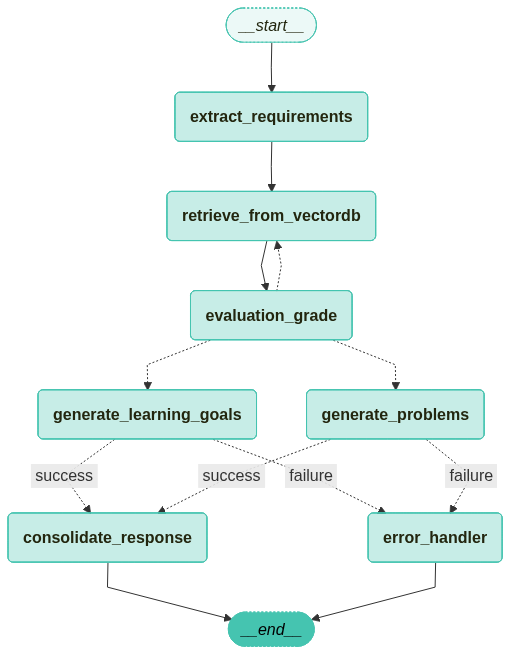

In [13]:
# 그래프 컴파일 및 시각화
from langchain_teddynote.graphs import visualize_graph
app = workflow.compile()

visualize_graph(app)

### 5. Execute
* 컴파일한 그래프를 실제로 실행하는 부분 입니다

In [14]:
import numpy as np
from psycopg2.extensions import register_adapter, AsIs

# numpy.float32 타입을 Python float으로 변환하도록 등록
# pgvector가 아래의 자료형을 인식할 수 있도록 하기 위함
register_adapter(np.float32, lambda a: AsIs(a.item())) 

In [15]:
# 실행할 프롬프트
user_prompt = "고등학교 1학년 수학 과목의 `집합`에 대한 내용을 수업하는데 효과적인 학습 목표랑 연습 문제를 만들어 주세요."

# 입력값 설정
inputs = {"prompt": user_prompt}

# 그래프 실행 및 결과 확인
final_state = app.invoke(inputs)

print("\n\n================ 최종 결과 ================")
print(final_state['final_response'])

-> 추출된 요구사항: school_level='고등학교' grade='1학년' subject='수학' content_requests=['학습 목표 생성', '문제 생성'] domain='집합' basecode=''

--- 2. 벡터 DB 검색 노드 실행 ---
[('[10기수2-02-02]', '두 집합 사이의 포함관계를 판단할 수 있다.', '고등', '10', '집합과 명제', '집합과 명제'), ('[10공수2-02-02]', '두 집합 사이의 포함관계를 판단할 수 있다.', '고등', '10', '집합과 명제', '집합과 명제'), ('[10기수2-02-01]', '집합의 개념을 이해하고, 집합을 표현할 수 있다.', '고등', '10', '집합과 명제', '집합과 명제')]
==== [GRADE DOCUMENTS] ====
==== GRADE: DOCUMENT RELEVANT ====
==== GRADE: DOCUMENT RELEVANT ====
==== GRADE: DOCUMENT RELEVANT ====

--- 라우팅: 생성할 콘텐츠 결정 ---
-> 다음 노드(병렬 실행): ['generate_learning_goals', 'generate_problems']

--- 4. 최종 답변 종합 노드 실행 ---
-> 최종 답변 생성 완료


================ 최종 결과 ================
요청하신 **고등학교 1학년 수학 - '집합'** 단원에 대한 콘텐츠입니다.

### 학습 목표
## 고등학교 1학년 수학 '집합' 단원 학습 목표

이 단원을 학습함으로써 학생들은 다음과 같은 목표를 달성할 수 있다.

---

**I. 집합의 기본 개념 이해 및 표현**

1.  **집합의 의미와 원소:**
    *   집합의 의미를 이해하고, 주어진 대상이 집합인지 아닌지 판단할 수 있다.
    *   원소와 집합의 관계를 이해하고, 기호 $\in$를 사용하여 나타낼 수 있다.
2.  **집합의 표현:**
    *   집합을 